#Summary

The goal of this notebook is to categorize customers into seven or eight different groups using a clustering model. To prepare the data we work with we load the csv files with commercial activity, socioeconomic and product data into a dataframe. Only those columns that stood out as interesting during the analysis are included in the dataframe to keep the number of features manageable.

Before we start with model building the product usage feature is summarized and encoded. We summarize whether the customer has ever hired one of the products with an expected revenue of 60€, 40€ and 10€. If they have, the value per pk_cid is "1". If not, it is "0". This way 13 different product features are reduced to only three. The second part of the feature preparation consists in scaling the age values.

When training the first model the number of features taking into account is again reduced based on our knowledge gained during the data analysis phase, only some of the prepared data is actually used. Then, we train a KMeans model with seven clusters and a MeanShift model with eight clusters.

Both models are evaluated by visualizing the clusters in a heatmap. Even though the The MeanShift clustering seems to differentiate slightly better in terms of product usage the KMeans is chosen as the final model since the sizes of the KMeans clusters are more balanced than the ones in the MeanShift model. At the end the number of clusters for the KMeans model is increased to eight, which helps make the clusters more distinctive in terms of product usage.


### 0) Import libraries

In [ ]:
#pandas, numpy and datetime
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

#scaling and modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1) Load data

Load all three csv files into separate dataframes. Only the columns that appeared interesting during the analysis will be loaded. The following columns will not be loaded:
*   'em_account_pp' (no customer has ever hired it)
*   'country' (99% ES)
*   'salary' (not a reliable feature)





First, we load the commercial activity df (all columns)

In [ ]:
df_com = pd.read_csv("/content/drive/MyDrive/easyMoney_data/data/commercial_activity_df.csv", index_col =0)
df_com.shape

(5962924, 6)

In [ ]:
df_com.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO


Next, the product data:

In [ ]:
cols = ['pk_cid', 'pk_partition', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit',
        'credit_card', 'payroll','pension_plan','payroll_account','emc_account', 'debit_card', 'em_account_p', 'em_acount']
df_pro = pd.read_csv("/content/drive/MyDrive/easyMoney_data/data/products_df.csv", usecols=cols)
df_pro.shape

(5962924, 16)

In [ ]:
df_pro.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-28,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


Then the sociodemographic data (leave out country and salary)

In [ ]:

cols=['pk_cid','pk_partition','gender','age','region_code','deceased']
df_soc = pd.read_csv("/content/drive/MyDrive/easyMoney_data/data/sociodemographic_df.csv", usecols=cols)
df_soc.shape

(5962924, 6)

In [ ]:
df_soc.head()

,pk_cid,pk_partition,region_code,gender,age,deceased
0,1375586,2018-01-28,29.0,H,35,N
1,1050611,2018-01-28,13.0,V,23,N
2,1050612,2018-01-28,13.0,V,23,N
3,1050613,2018-01-28,50.0,H,22,N
4,1050614,2018-01-28,50.0,V,23,N


### 2) Data preparation

#### 2.1) Update datatypes

'pk_partition' is changed into date format.

In [ ]:
df_com['pk_partition'] = pd.to_datetime(df_com['pk_partition'], format= '%Y-%m-%d')
df_pro['pk_partition'] = pd.to_datetime(df_pro['pk_partition'], format= '%Y-%m-%d')
df_soc['pk_partition'] = pd.to_datetime(df_soc['pk_partition'], format= '%Y-%m-%d')
display(df_com.dtypes)
display(df_pro.dtypes)
display(df_soc.dtypes)

pk_cid                      int64
pk_partition       datetime64[ns]
entry_date                 object
entry_channel              object
active_customer           float64
segment                    object
dtype: object

pk_cid                         int64
pk_partition          datetime64[ns]
short_term_deposit             int64
loans                          int64
mortgage                       int64
funds                          int64
securities                     int64
long_term_deposit              int64
credit_card                    int64
payroll                      float64
pension_plan                 float64
payroll_account                int64
emc_account                    int64
debit_card                     int64
em_account_p                   int64
em_acount                      int64
dtype: object

pk_cid                   int64
pk_partition    datetime64[ns]
region_code            float64
gender                  object
age                      int64
deceased                object
dtype: object

We need to identify entry date values that contain '02-29' of a non leap-year to '02-28' (so that the format can be converted to date)

In [ ]:
df_0229 = df_com[df_com['entry_date'].str.contains('02-29')]
display(df_0229['entry_date'].unique())

array(['2015-02-29', '2019-02-29'], dtype=object)

The identified values are changed to '02-28' and the data types are updated.

In [ ]:
df_com['entry_date'] = df_com['entry_date'].replace(['2015-02-29'], '2015-02-28')
df_com['entry_date'] = df_com['entry_date'].replace(['2019-02-29'], '2019-02-28')
df_com['entry_date'] = pd.to_datetime(df_com['entry_date'], format= '%Y-%m-%d')
df_com.dtypes

pk_cid                      int64
pk_partition       datetime64[ns]
entry_date         datetime64[ns]
entry_channel              object
active_customer           float64
segment                    object
dtype: object

#### 2.4) Dataframe merge

A unique identifier using 'pk_cid' and 'pk_partition' is created in the commercial data df:

In [ ]:
df_com['pk'] = df_com['pk_cid'].astype(str)+df_com['pk_partition'].astype(str)
df_com.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,pk
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,13755862018-01-28
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,10506112018-01-28
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,10506122018-01-28
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,10506132018-01-28
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,10506142018-01-28


A unique identifier using 'pk_cid' and 'pk_partition' is created in the product df

In [ ]:
df_pro['pk'] = df_pro['pk_cid'].astype(str)+df_pro['pk_partition'].astype(str)
df_pro.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,pk
0,1375586,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13755862018-01-28
1,1050611,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,10506112018-01-28
2,1050612,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,10506122018-01-28
3,1050613,2018-01-28,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,10506132018-01-28
4,1050614,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,10506142018-01-28


A unique identifier using 'pk_cid' and 'pk_partition' is created in the socioeconomic df

In [ ]:
df_soc['pk'] = df_soc['pk_cid'].astype(str)+df_soc['pk_partition'].astype(str)
df_soc.head()

,pk_cid,pk_partition,region_code,gender,age,deceased,pk
0,1375586,2018-01-28,29.0,H,35,N,13755862018-01-28
1,1050611,2018-01-28,13.0,V,23,N,10506112018-01-28
2,1050612,2018-01-28,13.0,V,23,N,10506122018-01-28
3,1050613,2018-01-28,50.0,H,22,N,10506132018-01-28
4,1050614,2018-01-28,50.0,V,23,N,10506142018-01-28


All three dataframes are sorted by the new unique identifier

In [ ]:
df_com.sort_values(by='pk')
df_pro.sort_values(by='pk')
df_soc.sort_values(by='pk')

,pk_cid,pk_partition,region_code,gender,age,deceased,pk
83145,1000028,2018-01-28,28.0,H,43,N,10000282018-01-28
398328,1000028,2018-02-28,28.0,H,43,N,10000282018-02-28
648478,1000028,2018-03-28,28.0,H,43,N,10000282018-03-28
895292,1000028,2018-04-28,28.0,H,43,N,10000282018-04-28
1055025,1000028,2018-05-28,28.0,H,43,N,10000282018-05-28
...,...,...,...,...,...,...,...
4150681,999892,2019-01-28,28.0,H,37,N,9998922019-01-28
4534978,999892,2019-02-28,28.0,H,37,N,9998922019-02-28
5003358,999892,2019-03-28,28.0,H,38,N,9998922019-03-28
5287361,999892,2019-04-28,28.0,H,38,N,9998922019-04-28


The sorted dataframes are merged:

In [ ]:
df = pd.merge(pd.merge(df_com,df_pro,on='pk'), df_soc,on='pk')
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,pk,pk_cid_y,pk_partition_y,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,pk_cid,pk_partition,region_code,gender,age,deceased
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,13755862018-01-28,1375586,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1375586,2018-01-28,29.0,H,35,N
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,10506112018-01-28,1050611,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1050611,2018-01-28,13.0,V,23,N
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,10506122018-01-28,1050612,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1050612,2018-01-28,13.0,V,23,N
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,10506132018-01-28,1050613,2018-01-28,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,1050613,2018-01-28,50.0,H,22,N
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,10506142018-01-28,1050614,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1050614,2018-01-28,50.0,V,23,N


In [ ]:
df.shape

(5962924, 29)

The merged df is exported for later use. As mentioned, it contains all columns except
*   'em_account_pp'
*   'country'
*   'salary'

No rows have been deleted so far.



In [ ]:
df.to_csv('/content/drive/MyDrive/easyMoney_data/data/df_merged.csv', index=False)

#### 2.5) Drop irrelevant rows and columns

Drop columns
*   duplicate "pk" columns from merge

Drop rows
*   deceased customers
*   constantly inactive customers with no products (see classification from analysis). These customers are not relevant for the segmentation, they should not even be classified as customers, rather as "leads".









In [ ]:
#drop duplicate "pk" columns from merge
df.drop(columns=["pk_cid_y","pk_partition_y", "pk_cid", "pk_partition","pk"], inplace=True)
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,deceased
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,N
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,N
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,N
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,50.0,H,22,N
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,50.0,V,23,N


In [ ]:
#drop rows with deceased customers
df = df[df['deceased']=='N']

In [ ]:
#drop 'deceased' column
df.drop(columns='deceased', inplace=True)

In [ ]:
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,50.0,H,22
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,50.0,V,23


Identify rows that have never been active and that have never hired any products, meaning that the sum of activity status and product usage is always 0.

In [ ]:
#sum up activity status and products hired
cols = ['active_customer','short_term_deposit',	'loans',
        'mortgage', 'funds',	'securities',	'long_term_deposit',	'credit_card',
        'payroll',	'pension_plan',	'payroll_account',	'emc_account',	'debit_card',	'em_account_p','em_acount']
df['products+activity'] = df[cols].sum(axis=1)
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,products+activity
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,1.0
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,1.0
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,50.0,H,22,1.0
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,50.0,V,23,2.0


Summarize information by customer ID, to see for which customers the sum of activity status and product usage is always 0.

In [ ]:
#summarize values by pk_cid
cust_ids_inactive = pd.DataFrame(df.groupby('pk_cid_x')['products+activity'].sum())
ids_to_drop = cust_ids_inactive[cust_ids_inactive['products+activity']==0].index

In [ ]:
#check list of pk_cids to drop
ids_to_drop

Int64Index([  19812,   20303,   25482,   26303,   26557,   30317,   31507,
              34191,   35077,   36611,
            ...
            1553679, 1553680, 1553681, 1553683, 1553684, 1553685, 1553686,
            1553687, 1553688, 1553689],
           dtype='int64', name='pk_cid_x', length=102162)

Drop customer IDs that are never active and never hire any products

In [ ]:
print("Shape before drop:",df.shape)

Shape before drop: (5961849, 24)


In [ ]:
#create new df without the customer IDs that were identified
df2 = df[~df['pk_cid_x'].isin(ids_to_drop)]

In [ ]:
print("Shape after drop:",df2.shape)

Shape after drop: (5036357, 24)


Impute missing values

In [ ]:
df2.isna().sum()

pk_cid_x                  0
pk_partition_x            0
entry_date                0
entry_channel         95708
active_customer           0
segment               96476
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
credit_card               0
payroll                  56
pension_plan             56
payroll_account           0
emc_account               0
debit_card                0
em_account_p              0
em_acount                 0
region_code            1865
gender                   25
age                       0
products+activity         0
dtype: int64

Six columns contain missing values, but only two of them will be imputed.
'segment' and 'gender' will be OneHotEncoded anyways, therefore it is only necessary to replace the missing values for 'payroll' and 'pension_plan'.

In [ ]:
df2['payroll'].fillna(0, inplace=True)
df2['pension_plan'].fillna(0, inplace=True)

<ipython-input-30-487eebbb05a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['payroll'].fillna(0, inplace=True)
<ipython-input-30-487eebbb05a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pension_plan'].fillna(0, inplace=True)


In [ ]:
df2.isna().sum()

pk_cid_x                  0
pk_partition_x            0
entry_date                0
entry_channel         95708
active_customer           0
segment               96476
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
credit_card               0
payroll                   0
pension_plan              0
payroll_account           0
emc_account               0
debit_card                0
em_account_p              0
em_acount                 0
region_code            1865
gender                   25
age                       0
products+activity         0
dtype: int64

### 3) Feature preparation

#### 3.1) Encoding

The goal is to not have too many possible feature columns in the end to keep the clustering as simple as possible. Therefore, features with a high number of categories like the entry channel and the region code will be summarized as much as possible.

Columns to be encoded:
- products with expected revenue of 10€, 40€ or 60€ except em account (summarize whether the customer has ever hired one of them or not. If they have, the value per pk_cid will be 1. If not, it will be 0.)
- segment (OneHotEncoding)
- gender (OneHotEncoding)

Add column to summarize whether or not the customer has hired one of the products from the category, then summarize data by customer ID

In [ ]:
#summarize products for which the expected revenue is about 10#€ (except em account, which almost everyone has)
df2['account_products'] = df2[['em_account_p', 'emc_account','payroll','payroll_account']].sum(axis=1)
cond = df2['account_products']>0
df2.loc[cond, 'account_products']=1
df2['account_products'].unique()

<ipython-input-32-7601254bef09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['account_products'] = df2[['em_account_p', 'emc_account','payroll','payroll_account']].sum(axis=1)


array([0., 1.])

In [ ]:
#summarize this information by customer ID
sum_by_cust_acc = pd.DataFrame(df2.groupby('pk_cid_x')['account_products'].sum()).reset_index()
sum_by_cust_acc.rename(columns={'account_products': 'acc_prod_by_cust'}, inplace=True)
cond = sum_by_cust_acc['acc_prod_by_cust'] >0
sum_by_cust_acc['acc_prod_by_cust']= np.where(cond, 1, 0)
sum_by_cust_acc['acc_prod_by_cust'].unique()

array([0, 1])

In [ ]:
sum_by_cust_acc

,pk_cid_x,acc_prod_by_cust
0,15891,0
1,16063,0
2,16203,0
3,16502,1
4,17457,0
...,...,...
354151,1553541,0
354152,1553552,0
354153,1553559,0
354154,1553565,0


In [ ]:
#summarize products for which the expected revenue is about 60€
df2['financing_products'] = df2[['debit_card','credit_card', 'loans']].sum(axis=1)
cond = df2['financing_products']>0
df2.loc[cond, 'financing_products']=1
df2['financing_products'].unique()

<ipython-input-35-ecb0d80a10f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['financing_products'] = df2[['debit_card','credit_card', 'loans']].sum(axis=1)


array([0, 1])

In [ ]:
#summarize this information by customer ID
sum_by_cust_fin = pd.DataFrame(df2.groupby('pk_cid_x')['financing_products'].sum()).reset_index()
sum_by_cust_fin.rename(columns={'financing_products': 'fin_prod_by_cust'}, inplace=True)
cond = sum_by_cust_fin['fin_prod_by_cust'] >0
sum_by_cust_fin['fin_prod_by_cust']= np.where(cond, 1, 0)
sum_by_cust_fin['fin_prod_by_cust'].unique()

array([0, 1])

In [ ]:
#summarize products for which the expected revenue is about 40€
df2['savings_products'] = df2[['pension_plan','securities', 'short_term_deposit','long_term_deposit','mortgage','funds']].sum(axis=1)
cond = df2['savings_products']>0
df2.loc[cond, 'savings_products']=1
df2['savings_products'].unique()

<ipython-input-37-3ec4faf11c3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['savings_products'] = df2[['pension_plan','securities', 'short_term_deposit','long_term_deposit','mortgage','funds']].sum(axis=1)


array([0., 1.])

In [ ]:
#summarize this information by customer ID
sum_by_cust_sav = pd.DataFrame(df2.groupby('pk_cid_x')['savings_products'].sum()).reset_index()
sum_by_cust_sav.rename(columns={'savings_products': 'sav_prod_by_cust'}, inplace=True)
cond = sum_by_cust_sav['sav_prod_by_cust'] >0
sum_by_cust_sav['sav_prod_by_cust']= np.where(cond, 1, 0)
sum_by_cust_sav['sav_prod_by_cust'].unique()

array([0, 1])

The new product columns are merged to the original df

In [ ]:
merged_df = pd.merge(df2, sum_by_cust_acc, on='pk_cid_x')
merged_df2 = pd.merge(merged_df, sum_by_cust_fin, on='pk_cid_x')
df3 = pd.merge(merged_df2, sum_by_cust_sav, on='pk_cid_x')
df3.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,products+activity,account_products,financing_products,savings_products,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0
1,1375586,2018-02-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0
2,1375586,2018-03-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0
3,1375586,2018-04-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0
4,1375586,2018-05-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,29.0,H,35,3.0,0.0,1,0.0,0,1,0


In [ ]:
df3.shape

(5036357, 30)

OneHotEncoding for categorical features ('segment', 'gender')

In [ ]:
oh_seg = pd.get_dummies(df3['segment'])
oh_gen = pd.get_dummies(df3['gender'])

Concat encoded columns with original df

In [ ]:
df4 = pd.concat([df3, oh_seg,oh_gen], axis=1)
df4.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,products+activity,account_products,financing_products,savings_products,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0
1,1375586,2018-02-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0
2,1375586,2018-03-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0
3,1375586,2018-04-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0
4,1375586,2018-05-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,29.0,H,35,3.0,0.0,1,0.0,0,1,0,0,1,0,1,0


#### 3.2) Scaling

Scale age column

In [ ]:
scaler = MinMaxScaler()

age_values = df4['age'].values.reshape(-1, 1)
df4['age_scaled'] = scaler.fit_transform(age_values)

df4.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,products+activity,account_products,financing_products,savings_products,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,age_scaled
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
1,1375586,2018-02-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
2,1375586,2018-03-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
3,1375586,2018-04-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
4,1375586,2018-05-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,29.0,H,35,3.0,0.0,1,0.0,0,1,0,0,1,0,1,0,0.320388


The scaled age values are plotted and compared to the original distribution

Text(0.5, 1.0, 'Age_scaled')

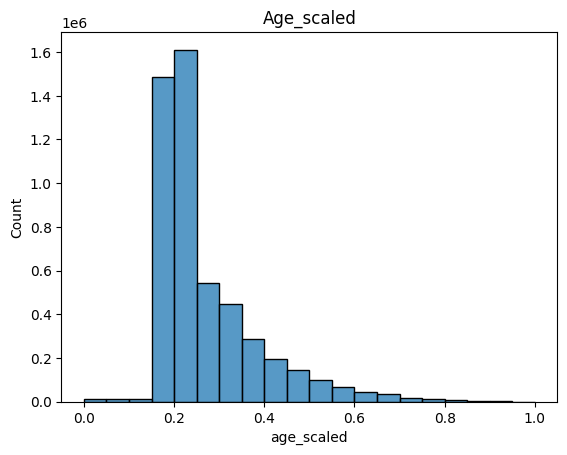

In [ ]:
sns.histplot(data=df4, x='age_scaled', bins=20)
plt.title('Age_scaled')

Text(0.5, 1.0, 'Age')

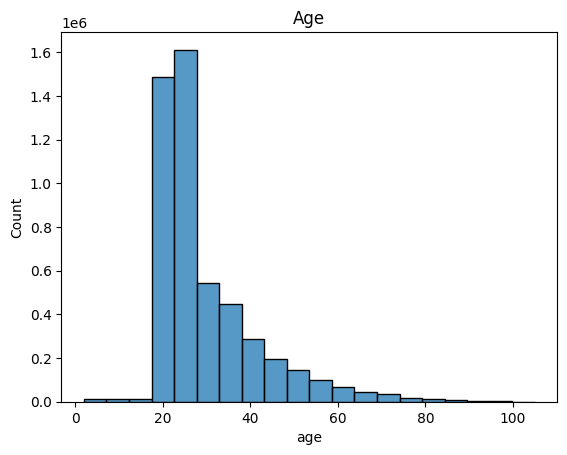

In [ ]:
sns.histplot(data=df4, x='age', bins=20)
plt.title('Age')

Scaled values look very similar to the original distribution, so the MinMax scaler can be kept. The scaled values for each unique age will be saved in a df so that it is always possible to see what each scaled value corresponds to.

In [ ]:
df_age = df4[['age','age_scaled']]
df_age.drop_duplicates(subset='age', keep='first', inplace=True)
df_age.sort_values(by='age',inplace=True)
df_age.T

<ipython-input-106-6b3d4df37f5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age.drop_duplicates(subset='age', keep='first', inplace=True)
<ipython-input-106-6b3d4df37f5d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age.sort_values(by='age',inplace=True)


,1449190,1449197,67540,67547,10680,10694,10663,10676,12760,12775,10646,10654,42223,10629,15880,15891,28924,41944,41953,48156,51,17,33,146,446,...,69939,31676,10864,10085,10100,44748,44760,233310,48832,48840,214732,84627,84643,354747,32135,32148,61598,413427,356849,356865,1115225,1280218,2264800,3110869,3110878
age,2.0,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.00000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.00000,...,81.00000,82.000000,83.000000,84.000000,85.000000,86.000000,87.000000,88.000000,89.00000,90.000000,91.000000,92.000000,93.000000,94.000000,95.000000,96.000000,97.00000,98.000000,99.000000,100.000000,101.000000,102.000000,103.000000,104.000000,105.0
age_scaled,0.0,0.009709,0.019417,0.029126,0.038835,0.048544,0.058252,0.067961,0.07767,0.087379,0.097087,0.106796,0.116505,0.126214,0.135922,0.145631,0.15534,0.165049,0.174757,0.184466,0.194175,0.203883,0.213592,0.223301,0.23301,...,0.76699,0.776699,0.786408,0.796117,0.805825,0.815534,0.825243,0.834951,0.84466,0.854369,0.864078,0.873786,0.883495,0.893204,0.902913,0.912621,0.92233,0.932039,0.941748,0.951456,0.961165,0.970874,0.980583,0.990291,1.0


Drop OneHotEncoded columns as well as pk_cid_x and pk_partition, which are not needed for the clustering:

In [ ]:
df_features = df4.drop(columns=['pk_partition_x','segment','gender'])
df_features.head()

,pk_cid_x,entry_date,entry_channel,active_customer,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,age,products+activity,account_products,financing_products,savings_products,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,age_scaled
0,1375586,2018-01-12,KHL,1.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
1,1375586,2018-01-12,KHL,1.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
2,1375586,2018-01-12,KHL,1.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
3,1375586,2018-01-12,KHL,1.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,35,2.0,0.0,0,0.0,0,1,0,0,1,0,1,0,0.320388
4,1375586,2018-01-12,KHL,1.0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,29.0,35,3.0,0.0,1,0.0,0,1,0,0,1,0,1,0,0.320388


Show feature columns

In [ ]:
df_features.columns

Index(['pk_cid_x', 'entry_date', 'entry_channel', 'active_customer',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit', 'credit_card', 'payroll', 'pension_plan',
       'payroll_account', 'emc_account', 'debit_card', 'em_account_p',
       'em_acount', 'region_code', 'age', 'products+activity',
       'account_products', 'financing_products', 'savings_products',
       'acc_prod_by_cust', 'fin_prod_by_cust', 'sav_prod_by_cust', '01 - TOP',
       '02 - PARTICULARES', '03 - UNIVERSITARIO', 'H', 'V', 'age_scaled'],
      dtype='object')

### 4) Feature selection

Select only a certain number of features for clustering, using our knowledge form the analysis
- Whether someone is an active customer
- Whether someone has one or all products for which the expected revenue is 10€, 40€ or 60€.
- Features with a high variance as per analysis: Age, Segments, Gender

A new df with all those features that we selected is created.

In [ ]:
features = ['active_customer','acc_prod_by_cust', 'fin_prod_by_cust', 'sav_prod_by_cust','age_scaled', '01 - TOP','02 - PARTICULARES',  '03 - UNIVERSITARIO','H','V']
df5 = df_features[features]
df5.head()

,active_customer,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,age_scaled,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V
0,1.0,0,1,0,0.320388,0,1,0,1,0
1,1.0,0,1,0,0.320388,0,1,0,1,0
2,1.0,0,1,0,0.320388,0,1,0,1,0
3,1.0,0,1,0,0.320388,0,1,0,1,0
4,1.0,0,1,0,0.320388,0,1,0,1,0


All column names are converted to a string, which is necessary in order to train the kmeans model:

In [ ]:
df5.columns = df5.columns.astype(str)

### 5) Model training

#### 5.1) KMeans

Specify number of clusters:

In [ ]:
num_clusters = 7

Instantiate model:

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

Fit model:

In [ ]:
kmeans.fit(df5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7, random_state=42)

#### 5.2) MeanShift

In [ ]:
df6 = df5.copy()

Define X:

In [ ]:
X = df6[features].values

Estimate bandwidth (Since this algorithm has no direct parameter to specify the number of clusters the bandwidth is adjusted until the number of clusters is 7 or 8.):

In [ ]:
bandwidth = 1.2

Perform Mean Shift clustering:

In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

Number of estimated clusters: 8


### 6) Model evaluation

#### 6.1) KMeans

Add cluster label to our features df:

In [ ]:
cluster_labels = kmeans.labels_
df5['Cluster'] = cluster_labels

<ipython-input-63-0f1e9a568ced>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Cluster'] = cluster_labels


Create dataframe with cluster means:

In [ ]:
cluster_means = pd.DataFrame(df5.groupby('Cluster').mean()).reset_index()
cluster_means

,Cluster,active_customer,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,age_scaled,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V
0,0,0.000000,0.007071,0.012791,0.004658,0.211050,0.001433,0.000000,0.978153,1.000000,0.000000
1,1,0.735397,0.196082,0.339489,0.067839,0.382485,0.000088,0.999411,0.000000,0.000000,0.999964
2,2,0.000000,0.009031,0.020456,0.006211,0.212933,0.002271,0.000000,0.973461,0.000000,1.000000
3,3,0.712829,0.177717,0.306062,0.076552,0.392448,0.001978,0.994141,0.000000,1.000000,0.000000
4,4,1.000000,0.076773,0.159044,0.064963,0.218864,0.033218,0.000000,0.938665,1.000000,0.000000
5,5,1.000000,0.093397,0.209204,0.074114,0.228327,0.050845,0.000000,0.911255,0.000000,1.000000
6,6,0.957328,0.987850,0.760423,0.992306,0.365655,0.102450,0.665849,0.216099,0.434688,0.565309


A heatmap is created to visualize the clusters:

In [ ]:
def heatmap (clusters, cluster_features):
  colors = [(0, 'darkblue'), (0.5, 'lightblue'), (1, 'purple')]
  custom_cmap = LinearSegmentedColormap.from_list("Custom Red Blue", colors)
  plt.figure(figsize=(10, 6))
  sns.heatmap(clusters[cluster_features], cmap=custom_cmap, annot=True, fmt='.2f')
  plt.xlabel('Features')
  plt.ylabel('Cluster')
  plt.title('Cluster Heatmap')
  plt.show()

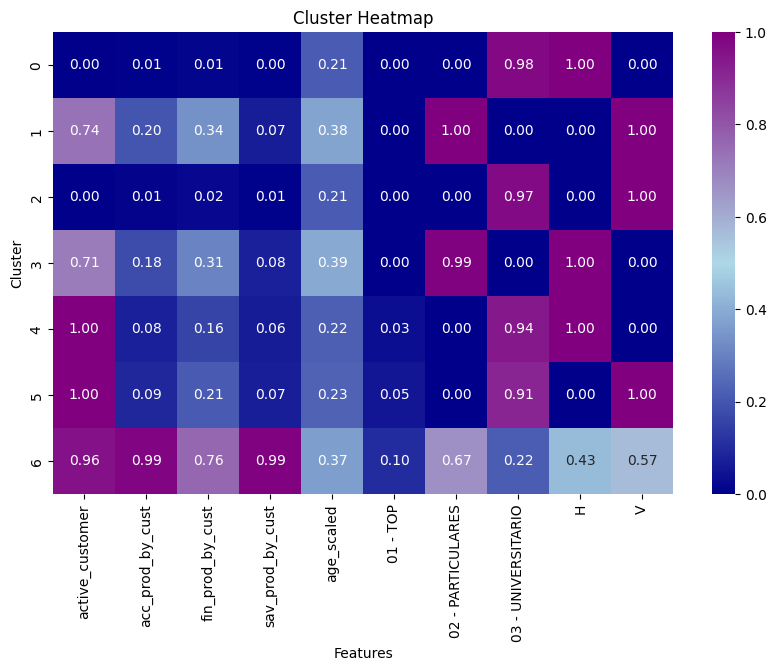

In [ ]:
heatmap(cluster_means,features)

Not all features seem to be equally important for the clustering. For example, the mean values for feature '01-TOP' are very low throughout all clusters.  Other features such as 'H' and 'V' (Female vs Male) seem to be well-suited for the clustering since there are some clusters with only males and some with only females. The clusters do not provide that much information regarding product usage, in clusters 0-5 the product usage is below 25% for all three product groups, only in cluster 6 the product groups are hired by 79% (finance products) and 99% (account and savings products)

In [ ]:
#add customer ID to df
df5_clustered = pd.concat([df5,df_features['pk_cid_x']],axis=1)
df5_clustered.shape

(5036357, 12)

In [ ]:
df5_clustered.head()

,active_customer,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,age_scaled,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,Cluster,pk_cid_x
0,1.0,0,1,0,0.320388,0,1,0,1,0,3,1375586
1,1.0,0,1,0,0.320388,0,1,0,1,0,3,1375586
2,1.0,0,1,0,0.320388,0,1,0,1,0,3,1375586
3,1.0,0,1,0,0.320388,0,1,0,1,0,3,1375586
4,1.0,0,1,0,0.320388,0,1,0,1,0,3,1375586


Check how many unique customer IDs there are in each cluster

In [ ]:
#create function to check unique customer Ids per cluster
def cust_per_cluster(df):
  cluster_alloc= pd.DataFrame(df.groupby('Cluster')['pk_cid_x'].nunique()).reset_index()
  cluster_alloc.rename(columns = {'active_customer':'customer ID count'})
  ax = sns.barplot(data=cluster_alloc, x='Cluster', y='pk_cid_x')
  plt.title('Unique customer IDs per cluster')
  return cluster_alloc, ax

(   Cluster  pk_cid_x
 0        0    101377
 1        1     55332
 2        2     81637
 3        3     43933
 4        4     54897
 5        5     52823
 6        6     32270,
 <Axes: title={'center': 'Unique customer IDs per cluster'}, xlabel='Cluster', ylabel='pk_cid_x'>)

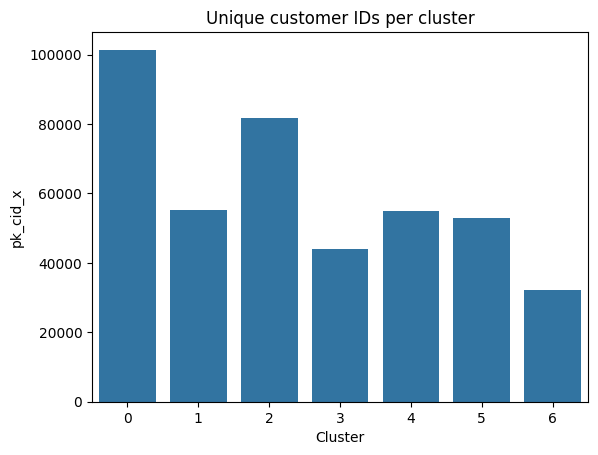

In [ ]:
cust_per_cluster(df5_clustered)

The biggest cluster is cluster 0, with over 100.000 unique customer IDs. Cluster 6 is the smallest with a bit more than 32.000 unique customer IDs.

#### 6.2) MeanShift

We identify the cluster centers and convert them into a dataframe:

In [ ]:
cluster_centers = ms.cluster_centers_
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)

cluster_centers_df

,active_customer,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,age_scaled,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V
0,0.289148,0.001714,0.056202,0.000133,0.208973,0.000000,0.000000,0.986605,1.0,0.0
1,0.305016,0.002078,0.079344,0.000431,0.210926,0.000000,0.000000,0.984836,0.0,1.0
2,0.802242,0.346121,0.409666,0.235453,0.377487,0.000000,0.982249,0.000000,0.0,1.0
3,0.738266,0.163942,0.291727,0.043875,0.384887,0.000000,0.970453,0.000000,1.0,0.0
4,0.989043,0.976293,0.833806,0.881151,0.357470,0.000000,0.768127,0.223052,1.0,0.0
5,0.940635,0.963215,0.639372,0.817293,0.244675,0.000000,0.000000,0.982237,0.0,1.0
6,1.000000,0.508800,0.198576,0.586773,0.439393,0.753393,0.000000,0.000000,0.0,1.0
7,1.000000,0.381938,0.000000,0.483792,0.434395,0.633896,0.000000,0.000000,1.0,0.0


The clusters are visualized:

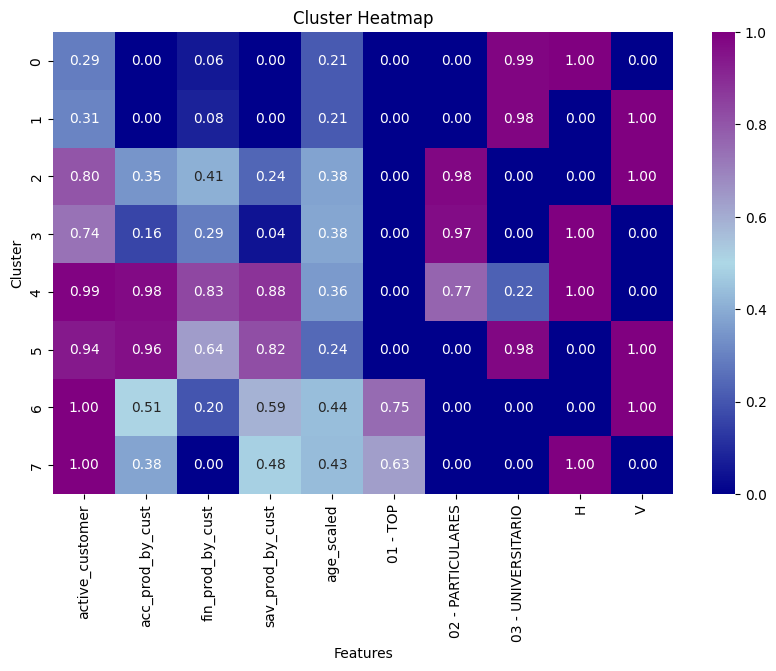

In [ ]:
heatmap(cluster_centers_df, features)

In this model the feature "01-TOP" seems to be more relevant than in the KMeans model as there are cluster 6 and 7 with 75% and 63% customers from this segment, respectively. There is also more differentiation in terms of product usage. The mean values for product usage do not only go from extremely high to extremely low, there are also some values in between.

Next, we identify the cluster labels for each data point and save the cluster allocation of each row.

In [ ]:
cluster_labels = ms.labels_
df6['Cluster'] = cluster_labels

In [ ]:
df6_clustered = pd.concat([df6,df_features['pk_cid_x']],axis=1)
df6_clustered.shape

(5036357, 12)

The number of unique customer Ids per cluster is checked:

(   Cluster  pk_cid_x
 0        0    130151
 1        1    103679
 2        2     68828
 3        3     41717
 4        4     17523
 5        5      7943
 6        6     23252
 7        7     21064,
 <Axes: title={'center': 'Unique customer IDs per cluster'}, xlabel='Cluster', ylabel='pk_cid_x'>)

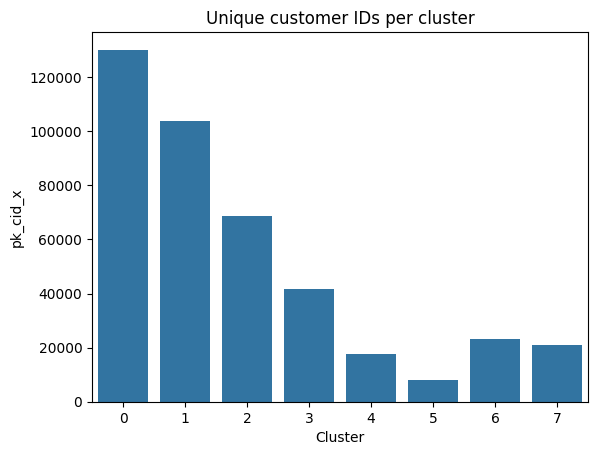

In [ ]:
cust_per_cluster(df6_clustered)

Cluster 1 is the largest cluster with over 130,000 unique customer IDs. The smallest one is cluster 5 with only a bit less than 8000 customers. The two most interesting clusters with high product usage, cluster 4 and 5, include around 26,000 customer IDs combined.

### 7) Model optimization

The MeanShift clustering seems to differentiate slightly better in terms of product usage. But it looks like this algorithm produces either very large clusters with many unique customer IDs, or very small ones, since the biggest cluster has over 130,000 unique customer IDs and the smallest one less than 8,000. It would be possible to try and create bigger clusters by changing the features, but then the number of clusters might also change since it is not possible to control this with a direct parameter, and there is a clear restriction of 7 or 8 clusters in this exercise. In the Kmeans model, on the other hand, the number of unique customer IDs is slightly more balanced, with the biggest cluster including over 100,000 and the smalles cluster around 32,000 unique customer IDs.

Therefore, the next step is to asjust the KMeans clustering to see if it is possible to obtain a better cluster differentiation in terms of product usage by adjusting the parameters.

A new df is created for the second model:

In [ ]:
df8 = df_features[features]
df8.head()

,active_customer,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,age_scaled,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V
0,1.0,0,1,0,0.320388,0,1,0,1,0
1,1.0,0,1,0,0.320388,0,1,0,1,0
2,1.0,0,1,0,0.320388,0,1,0,1,0
3,1.0,0,1,0,0.320388,0,1,0,1,0
4,1.0,0,1,0,0.320388,0,1,0,1,0


The third model is instantiated:

In [ ]:
kmeans2 = KMeans(n_clusters=8, random_state=42)

Fit the model:

In [ ]:
kmeans2.fit(df8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=42)

The cluster labels are added to the features:

In [ ]:
cluster_labels3 = kmeans2.labels_
df8['Cluster'] = cluster_labels3

<ipython-input-112-b1b3249390a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['Cluster'] = cluster_labels4


A dataframe with Cluster means is created:

In [ ]:
cluster_means3 = pd.DataFrame(df8.groupby('Cluster').mean()).reset_index()
cluster_means3

,Cluster,active_customer,acc_prod_by_cust,fin_prod_by_cust,sav_prod_by_cust,age_scaled,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V
0,0,1.000000,0.025934,0.172815,0.003242,0.208589,0.002514,0.000000,0.967833,1.000000,0.000000
1,1,0.000000,0.009031,0.020471,0.006211,0.212940,0.002273,0.000000,0.973447,0.000000,1.000000
2,2,0.715609,0.149192,0.289294,0.058871,0.381658,0.000015,0.999854,0.000000,0.000000,0.999961
3,3,0.701816,0.128412,0.265510,0.062043,0.391623,0.000497,0.997720,0.000000,1.000000,0.000000
4,4,0.959566,0.921892,0.684331,0.853699,0.371031,0.150826,0.631283,0.201439,0.000000,1.000000
5,5,0.962473,0.928409,0.659070,0.877326,0.367429,0.135526,0.585958,0.261405,0.999996,0.000000
6,6,0.000000,0.007070,0.012831,0.004658,0.211064,0.001435,0.000000,0.978114,1.000000,0.000000
7,7,1.000000,0.037596,0.229527,0.007569,0.214236,0.004746,0.000000,0.957288,0.000000,1.000000


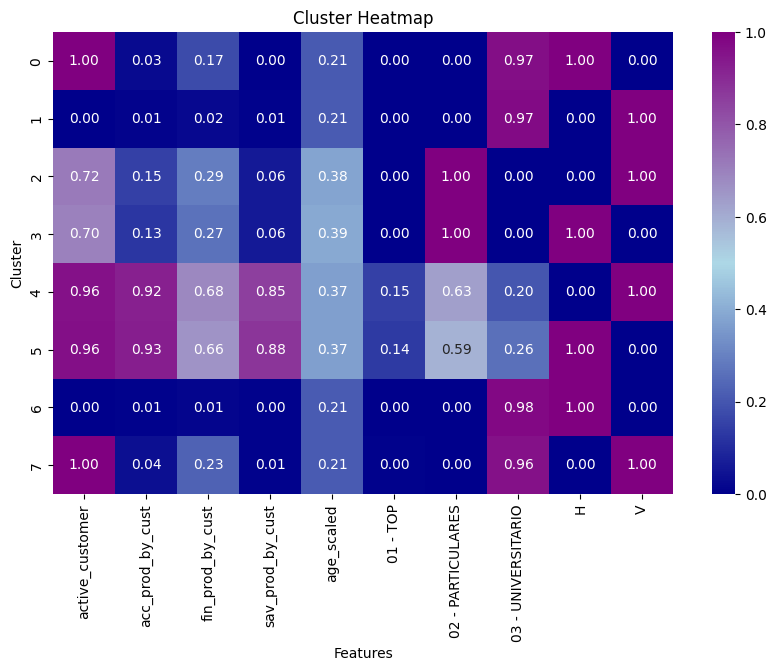

In [ ]:
heatmap(cluster_means3, features)

After increasing the number of clusters to 8 it becomes evident that clusters 4 and 5 are the ones in which the customers use the most products. It is also interesting to see that the most common segment in these clusters is '02-PARTICULARES'. The segment '01-TOP' is 0 for all clusters except for clusters 4 and 5. As it is known from the analysis the number of '01-TOP' customers in the datset is not very high. Now clusters 4 and 5 show that the few customers from the '01-TOP' segment tend to be active and hire products since they are only present in these two clusters. Cluster 4 includes only males and cluster 5 includes only females.

We need to check which age the 'age_scaled' values correspond to:

In [ ]:
df_age[(df_age['age_scaled']>0.21)&(df_age['age_scaled']<0.42)]

,age,age_scaled
33,24,0.213592
146,25,0.223301
446,26,0.233010
533,27,0.242718
336,28,0.252427
1380,29,0.262136
1118,30,0.271845
693,31,0.281553
659,32,0.291262
668,33,0.300971


The mean age in clusters 0, 1, 6 and 7 is 24, in clusters 2-5 on the other hand the meadian age is between 41 and 43.

The customer IDs are added to our main dataframe:

In [ ]:
df8_clustered = pd.concat([df8,df_features['pk_cid_x']],axis=1)
df8_clustered.shape

(5036357, 12)

We check the number of unique customer IDs per cluster:

(   Cluster  pk_cid_x
 0        0     51050
 1        1     81651
 2        2     52318
 3        3     41106
 4        4     25824
 5        5     20594
 6        6    101428
 7        7     47704,
 <Axes: title={'center': 'Unique customer IDs per cluster'}, xlabel='Cluster', ylabel='pk_cid_x'>)

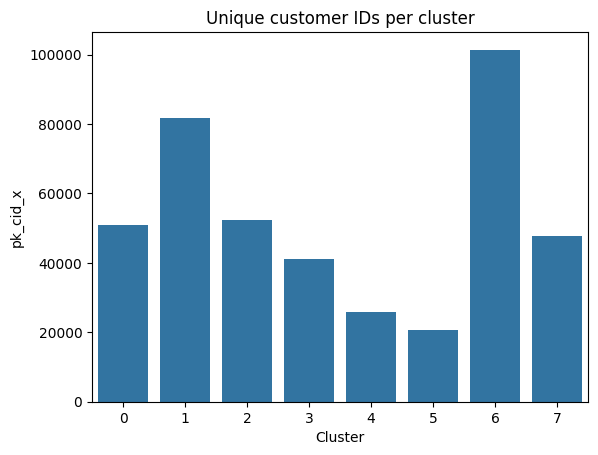

In [ ]:
cust_per_cluster(df8_clustered)

Cluster 6 is the biggest cluster with a bit over 100.000 unique customer IDs, cluster 5 is the smallest with a bit over 20.000. The two clusters in which the customers are most likely to hire a product from the three product groups, clusters 4 and 5, include over 45.000 unique customer IDs in total.

The cluster allocation per customer ID is saved in a csv file for future use.

In [ ]:
df_clusters = df8_clustered[['pk_cid_x', 'Cluster']]
df_clusters.rename(columns={'pk_cid_x': 'pk_cid'}, inplace=True)
df_clusters.drop_duplicates(keep='first', inplace=True)
df_clusters.head()

<ipython-input-97-2d27487b2de2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters.rename(columns={'pk_cid_x': 'pk_cid'}, inplace=True)
<ipython-input-97-2d27487b2de2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters.drop_duplicates(keep='first', inplace=True)


,pk_cid,Cluster
0,1375586,4
17,1050611,0
34,1050612,0
51,1050613,3
65,1050614,1


In [ ]:
df_clusters.to_csv('/content/drive/MyDrive/easyMoney_data/data/clusters.csv', index=False)